# This is a full pipeline with keypoints prediction using RNN in reconstruction mode for VoxCeleb dataset

# Import functions

In [1]:
import os   
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from Training_Prediction.FOMM.Source_Model.logger import Logger, Visualizer
import numpy as np
import imageio
from Training_Prediction.FOMM.Source_Model.sync_batchnorm import DataParallelWithCallback
from Training_Prediction.PREDICTOR.RNN import GRUModel
from Training_Prediction.FOMM.Source_Model.augmentation import SelectRandomFrames, SelectFirstFrames_two, VideoToTensor
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
from Training_Prediction.FOMM.Source_Model.frames_dataset import FramesDataset
import tensorflow.compat.v1 as tf
import pickle
from Training_Prediction.PREDICTOR.Source_Model.prediction_toplevel import KPDataset,get_data_from_dataloader_60
import gc
import pickle
import yaml
from Training_Prediction.FOMM.Source_Model.modules.generator import OcclusionAwareGenerator,calculate_frechet_distance,compute_fvd
from Training_Prediction.FOMM.Source_Model.modules.keypoint_detector import KPDetector
#from Training_Prediction.FOMM.Source_Model.logger import Logger, Visualizer, Visualizer_slow
from Training_Prediction.FOMM.Source_Model.logger import Logger, Visualizer

from torch import nn
import tensorflow.compat.v1 as tf
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import shutil
import subprocess
import imageio
import json
import os, sys
from PIL import Image

import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]='0'

2024-07-24 01:19:50.205893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 01:19:51.456196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def save_frames_as_png(frames, png_dir):
    for idx, frame in enumerate(frames):
        frame_path = os.path.join(png_dir, f'video_frame_{idx:04d}.png')
        imageio.imsave(frame_path, (255 * frame).astype(np.uint8))

In [6]:
def convert_png_to_mp4(png_dir,mp4_dir,video_number):
    if not png_dir.endswith('/'):
        png_dir += '/'
    if not mp4_dir.endswith('/'):
        mp4_dir += '/'
    
    input_pattern = f"{png_dir}video_frame_%04d.png"
    output_file = f"{mp4_dir}video_{video_number:02d}.mp4"
    command = (f'ffmpeg -y -r 60 -i {png_dir}/video_frame_%04d.png -pix_fmt yuv420p -profile:v high -level:v 4.1 -crf:v 20 -movflags +faststart {mp4_dir}/video_{video_number:02d}.mp4')
    os.system(command)

In [7]:
def convert_png_to_y4m(png_dir, y4m_dir, video_number):
    if not png_dir.endswith('/'):
        png_dir += '/'
    if not y4m_dir.endswith('/'):
        y4m_dir += '/'
    
    input_pattern = f"{png_dir}video_frame_%04d.png"
    output_file = f"{y4m_dir}video_{video_number:02d}.y4m"
    
    command = (f'ffmpeg -y -i {input_pattern} -r 25 -pix_fmt yuv444p {output_file}')    
    os.system(command)

In [8]:
def run_vmaf(driving_vid, generated_vid, output_path):
    if driving_vid[-3:] != 'y4m':
         raise Exception('Video must be in y4m format.')
    if generated_vid[-3:] != 'y4m':
         raise Exception('Video must be in y4m format.')
    if output_path[-4:] != 'json':
        raise Exception('Output file must be in json format')
    
    command = (f'vmaf --reference {driving_vid} --distorted {generated_vid} --model version=vmaf_v0.6.1 --output {output_path} --json')
    os.system(command)

# Define RNN

In [9]:
# Instantiate the model 
input_dim = 60
hidden_dim = 256
output_dim = input_dim
num_layers = 3
learning_rate = 0.001
num_epochs = 100
model = GRUModel(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# After RNN is trained, load saved model

In [10]:
# Load the saved parameters
model.load_state_dict(torch.load('Checkpoints/RNN_3883videos_vox_12-12.pth')) # 12-12 frames
# model.load_state_dict(torch.load('Checkpoints/RNN_3883videos_vox_6-6.pth')) # 6-6 frames

# Set the model to evaluation mode (important if using dropout or batch normalization)
model.eval()

GRUModel(
  (gru): GRU(60, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=60, bias=True)
)

# Import keypoints of 44 VoxCeleb test videos

In [11]:
with open("kp_test_44_vox.pkl", "rb") as f:
    kp_time_series = pickle.load(f)
len(kp_time_series)

44

# Convert list of keypoints to dictionary

In [12]:
for video_idx in range(len(kp_time_series)):
    kp_time_series[video_idx] = kp_time_series[video_idx]['kp']

kp_dict_init = []
for video_idx in range(len(kp_time_series)): # 
    init_mean = []
    init_jacobian = []
    for frame_idx in range(len(kp_time_series[video_idx])):
        kp_mean = kp_time_series[video_idx][frame_idx]['value'].reshape(1,10,2)
        kp_mean = torch.tensor(kp_mean)
        kp_jacobian = kp_time_series[video_idx][frame_idx]['jacobian'].reshape(1,10,2,2)
        kp_jacobian = torch.tensor(kp_jacobian)

        init_mean.append(kp_mean)
        init_jacobian.append(kp_jacobian)

    init_mean = torch.cat(init_mean)
    init_jacobian = torch.cat(init_jacobian)

    init_mean = torch.reshape(init_mean,(1,init_mean.shape[0],init_mean.shape[1],init_mean.shape[2]))
    init_jacobian = torch.reshape(init_jacobian,(1,init_jacobian.shape[0],10,2,2))

    if torch.cuda.is_available():
        # add tensor to cuda
        init_mean = init_mean.to('cuda:0')
        init_jacobian = init_jacobian.to('cuda:0')

    kp_dict_both = {"value":init_mean,"jacobian":init_jacobian}
    kp_dict_init.append(kp_dict_both)

# Apply min-max std to keypoints and convert to batches

In [13]:
kp_list_test = []
for video_idx in range(len(kp_dict_init)):
    kp_one_video = torch.cat((kp_dict_init[video_idx]['value'], kp_dict_init[video_idx]['jacobian'].reshape(1,-1,10,4)),dim=-1).reshape(-1,60)
    kp_one_video_array = np.array(kp_one_video.cpu())
    kp_list_test.append(kp_one_video_array)
    
#####  min-max std to 60 dimensions of selected one video ######
kp_list_test_std = []
min_list = []
range_list = []
for video_idx in range(len(kp_list_test)):
    data = kp_list_test[video_idx]
    data_length = len(kp_list_test[video_idx])
    step_interval = 12 # choose between 12 frames or 24 frames 
    min_required_steps = 2*step_interval
    selected_data = []
    for i in range(0, data_length - min_required_steps+1, 2 * step_interval):
        selected_data.extend(data[i:i + step_interval])
    min_values = np.min(selected_data,axis=0) # 60 mins of one selected video in the loop
    max_values = np.max(selected_data,axis=0) # 60 maxs of one selected video in the loop 
    range_values = max_values - min_values 
    kp_one_video_std = (kp_list_test[video_idx] - min_values) / range_values
    kp_list_test_std.append(kp_one_video_std)
    min_list.append(min_values)
    range_list.append(range_values)

trajs = kp_list_test_std
print(len(trajs))
print(trajs[0].shape)

44
(118, 60)


In [14]:
######### convert into batches:
frames = min_required_steps
input_frames = int(frames / 2)
data_batch_test = []
for t,x in enumerate(kp_list_test_std):
    if x.shape[0] >= frames:
        num_full_batches = x.shape[0] // frames
        for arr in np.array_split(x[:num_full_batches * frames], num_full_batches):
            data_batch_test.append(arr)
print(f'test dataset batches:', len(data_batch_test))
print(data_batch_test[0].shape)

test dataset batches: 529
(24, 60)


In [15]:
###### test dataset:

test_data_reshape = np.array(data_batch_test).reshape(-1,frames,60)
test_data_reshape.shape

(529, 24, 60)

# Predict keypoints using trained model:

In [16]:
# test dataset
validation_data = test_data_reshape

# evaluate model:
validation_input = torch.tensor(validation_data[:,:input_frames], dtype = torch.float32) # input: [24,10,17]
kp_gt = torch.tensor(validation_data[:,input_frames:], dtype = torch.float32) # gtoundtruth: [24,10,17]
pred = model(validation_input) # outputs: [24,10,30]

print(kp_gt.shape)
print(pred.shape)

torch.Size([529, 12, 60])
torch.Size([529, 12, 60])


# Generate unstd keypoints 

In [17]:
# save num_batches for each video:
num_batch_video = []
num_full_batches_all = 0
for t,x in enumerate(kp_list_test_std):
    if x.shape[0] > frames:
        num_full_batches = x.shape[0] // frames
        num_full_batches_all += num_full_batches
        num_batch_video.append(num_full_batches)
print(f'number of batches of each video:', len(num_batch_video))

number of batches of each video: 44


In [18]:
# first half of frames: groundtruth; last half of frames: predicted
test_gt_pred = np.concatenate((test_data_reshape[:,:input_frames], pred.detach().numpy()), axis = 1)
test_gt_pred.shape

(529, 24, 60)

In [19]:
# unstd for each video:
test_video_unstd_list = []
for video_idx in range(len(num_batch_video)):
    test_video = test_gt_pred[sum(num_batch_video[:video_idx]):sum(num_batch_video[:video_idx+1])]
    test_video_unstd = test_video * range_list[video_idx] + min_list[video_idx]
    test_video_unstd_list.append(test_video_unstd) # unstd video keypoints

# Optical flow and generator

In [20]:
####### call the config functions and inference dataloader #########
config="./config/abs-vox.yml"

# Test dataset
with open(config) as f:
    config = yaml.safe_load(f)
dataset = FramesDataset(is_train=(False), **config['dataset_params'],mode="RNN") # test

print(len(dataset))
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)

### call the functions        
generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                            **config['model_params']['common_params'])

log_dir="./log/test-reconstruction-vox"
checkpoint="./Training_Prediction/FOMM/Trained_Models/vox-cpk.pth.tar"

if checkpoint is not None:
    Logger.load_cpk(checkpoint, generator=generator, kp_detector=kp_detector)
else:
    raise AttributeError("Checkpoint should be specified for mode='reconstruction'.")
    
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
        
pred_png_dir = os.path.join(log_dir, 'prediction/prediction_png')
pred_mp4_dir = os.path.join(log_dir, 'prediction/prediction_mp4')
pred_y4m_dir = os.path.join(log_dir, 'prediction/prediction_y4m')
driving_png_dir = os.path.join(log_dir, 'prediction/driving_png')
driving_mp4_dir = os.path.join(log_dir, 'prediction/driving_mp4')
driving_y4m_dir = os.path.join(log_dir, 'prediction/driving_y4m')
rnn_vmaf_output = os.path.join(log_dir, 'prediction/vmaf_json_output_rnn')

log_dir = os.path.join(log_dir, 'prediction')

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(pred_png_dir):
    os.makedirs(pred_png_dir)
if not os.path.exists(pred_mp4_dir):
    os.makedirs(pred_mp4_dir)
if not os.path.exists(pred_y4m_dir):
    os.makedirs(pred_y4m_dir)

if not os.path.exists(driving_png_dir):
    os.makedirs(driving_png_dir)
if not os.path.exists(driving_mp4_dir):
    os.makedirs(driving_mp4_dir)
if not os.path.exists(driving_y4m_dir):
    os.makedirs(driving_y4m_dir)

if not os.path.exists(rnn_vmaf_output):
    os.makedirs(rnn_vmaf_output)

if torch.cuda.is_available():
    generator = DataParallelWithCallback(generator)
    kp_detector = DataParallelWithCallback(kp_detector)

generator.eval()
kp_detector.eval()

prediction_params = config['prediction_params']

num_epochs = prediction_params['num_epochs']
lr = prediction_params['lr']
bs = prediction_params['batch_size']
num_frames = prediction_params['num_frames']
loss_list_total = []
fvd_list_total = []

Use predefined train-test split.
using videos from test directory
['id10280#NXjT3732Ekg#001093#001192.mp4', 'id10281#NHARUN9OhSo#000605#000886.mp4', 'id10281#NHARUN9OhSo#001059#001210.mp4', 'id10281#NHARUN9OhSo#002098#002175.mp4', 'id10281#NHARUN9OhSo#002209#002570.mp4', 'id10281#NHARUN9OhSo#006609#006906.mp4', 'id10281#NHARUN9OhSo#006912#007284.mp4', 'id10281#NHARUN9OhSo#007425#007663.mp4', 'id10282#IDA_ElNHLn4#000674#000852.mp4', 'id10282#IDA_ElNHLn4#001226#001390.mp4', 'id10283#N69Hp2DGMLk#000519#000619.mp4', 'id10283#N69Hp2DGMLk#000721#000842.mp4', 'id10283#N69Hp2DGMLk#000893#001589.mp4', 'id10283#N69Hp2DGMLk#004133#005157.mp4', 'id10283#N69Hp2DGMLk#005157#005316.mp4', 'id10283#N69Hp2DGMLk#005931#006184.mp4', 'id10283#N69Hp2DGMLk#006184#006353.mp4', 'id10283#N69Hp2DGMLk#006405#006583.mp4', 'id10283#N69Hp2DGMLk#006600#007118.mp4', 'id10283#N69Hp2DGMLk#007129#007281.mp4', 'id10283#r9-0pljhZqs#002414#002769.mp4', 'id10283#r9-0pljhZqs#003725#003847.mp4', 'id10283#r9-0pljhZqs#004062#004

/opt/conda/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
#########  FOMM+RNN ########
mse_list_videos = []
for it, x in tqdm(enumerate(dataloader)):
        if config['reconstruction_params']['num_videos'] is not None:
            if it > config['reconstruction_params']['num_videos']:
                break

        # Clear the PNG directories for each iteration of the outer loop
        shutil.rmtree(pred_png_dir, ignore_errors=True)
        os.makedirs(pred_png_dir)
        
        shutil.rmtree(driving_png_dir, ignore_errors=True)
        os.makedirs(driving_png_dir)
            
        with torch.no_grad():
            predictions = []
            driving_frames = []
                
            ######## keypoints ########
            kp_driving_video = test_video_unstd_list[it].reshape(-1,10,6)
            kp_driving_video = torch.tensor(kp_driving_video)
            kp_source = {"value":kp_driving_video[0,:,:2].reshape(1,10,2),"jacobian":kp_driving_video[0,:,2:].reshape(1,10,2,2)} # kp of the ith frame      
            
        ##### Start generator
        mse_list_frames = []
        for i in range(((x['video'].shape[2])//frames)*frames): # cut the last <24 frames
            source = x['video'][:, :, 0]
            driving = x['video'][:, :, i]
            kp_driving = {"value":kp_driving_video[i,:,:2],"jacobian":kp_driving_video[i,:,2:]} # kp of the ith frame
            kp_driving['value'] = kp_driving['value'].reshape(1,10,2)
            kp_driving['jacobian'] = kp_driving['jacobian'].reshape(1,10,2,2)
            out = generator(source, kp_source=kp_source, kp_driving=kp_driving)
            out['kp_source'] = kp_source
            out['kp_driving'] = kp_driving
            del out['sparse_deformed']
            driving_frames.append(np.transpose(driving.data.cpu().numpy(), [0,2,3,1])[0])
            predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
            mse_list_frames.append(np.mean(np.square(driving.cpu().numpy() - out['prediction'].detach().cpu().numpy())))
        mse_list_videos.append(mse_list_frames)
            
        #Save frames as png files
#        save_frames_as_png(predictions, pred_png_dir)
#        save_frames_as_png(driving_frames,driving_png_dir)
    
        #Convert frames in png format to videos in y4m format
#        convert_png_to_y4m(pred_png_dir, pred_y4m_dir, it)
#        convert_png_to_y4m(driving_png_dir, driving_y4m_dir, it)
    
    #    convert_png_to_mp4(pred_png_dir,pred_mp4_dir,it)
    
        #Run VMAF on the y4m-format videos
#        run_vmaf(driving_y4m_dir+f'/video_{it:02d}.y4m',pred_y4m_dir+f'/video_{it:02d}.y4m',rnn_vmaf_output+f'/vmaf_{it:02d}.json')
            
    #    predictions = np.concatenate(predictions, axis=1)

0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
44it [05:17,  7.22s/it]


Text(0.5, 1.0, 'Frame-by-Frame Mean Square Error Distribution with RNN')

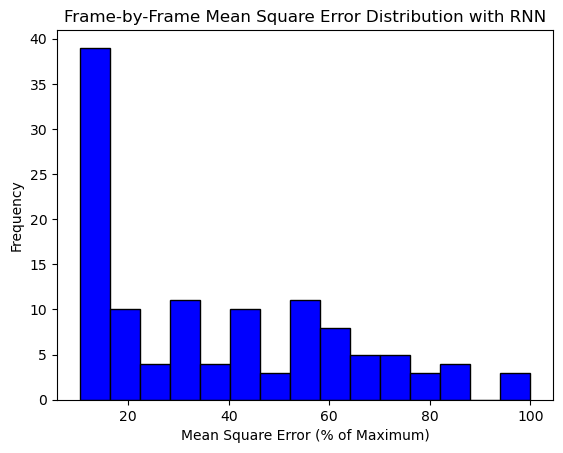

In [27]:
#Make Histogram for Frame-by-Frame MSE
example_video = mse_list_videos[10]
frame_max = np.max(example_video)
frames_norm = (example_video/frame_max)*100

# Create the histogram
plt.hist(frames_norm, bins=15, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Mean Square Error (% of Maximum)')
plt.ylabel('Frequency')
plt.title('Frame-by-Frame Mean Square Error Distribution with RNN')


In [44]:
#Read all VMAF outputs into a list variable
vmaf_outputs = []
for output_num in range(0,44):
    with open(rnn_vmaf_output + f'/vmaf_{output_num:02d}.json','r') as file:
        vmaf_outputs.append(json.load(file))

In [45]:
#Get all per-video VMAF scores 
vmaf_scores = []
for score in vmaf_outputs:
    vmaf_scores.append(score['pooled_metrics']['vmaf']['mean'])
#10

In [67]:
#Get all per-video MSE scores
mse_scores = []
for video in mse_list_videos:
    mse_scores.append(np.mean(video))

In [77]:
#Take one video as an example of per-frame scores
vmaf_example_video = vmaf_outputs[10]['frames']
frame_vmaf_scores = []
for frame in vmaf_example_video:
    frame_vmaf_scores.append(frame['metrics']['vmaf'])
mse_example_video = mse_list_videos[10]

(array([17., 23., 10.,  5.,  2.,  0.,  4.,  3.,  5., 11., 19., 12.,  3.,
         2.,  4.]),
 array([ 0.        ,  3.34970193,  6.69940387, 10.0491058 , 13.39880773,
        16.74850967, 20.0982116 , 23.44791353, 26.79761547, 30.1473174 ,
        33.49701933, 36.84672127, 40.1964232 , 43.54612513, 46.89582707,
        50.245529  ]),
 <BarContainer object of 15 artists>)

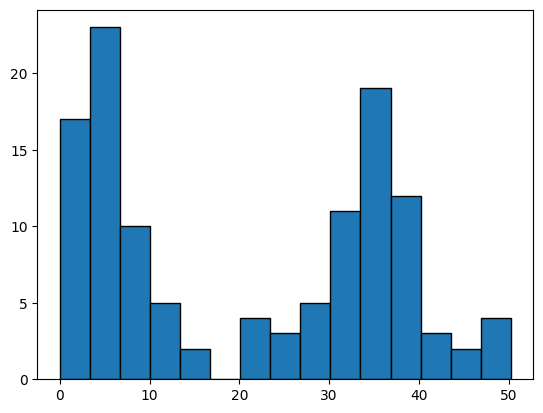

In [58]:
#Within-video VMAF-Frame Distribution
plt.hist(frame_vmaf_scores, bins=15, edgecolor = 'black')
plt.xlabel('VMAF Score')
plt.title('Distribution of Frame-by-Frame VMAF Scores for RNN')

(array([39., 10.,  4., 11.,  4., 10.,  3., 11.,  8.,  5.,  5.,  3.,  4.,
         0.,  3.]),
 array([0.00169127, 0.00267163, 0.00365198, 0.00463233, 0.00561269,
        0.00659304, 0.00757339, 0.00855375, 0.0095341 , 0.01051446,
        0.01149481, 0.01247516, 0.01345552, 0.01443587, 0.01541622,
        0.01639658]),
 <BarContainer object of 15 artists>)

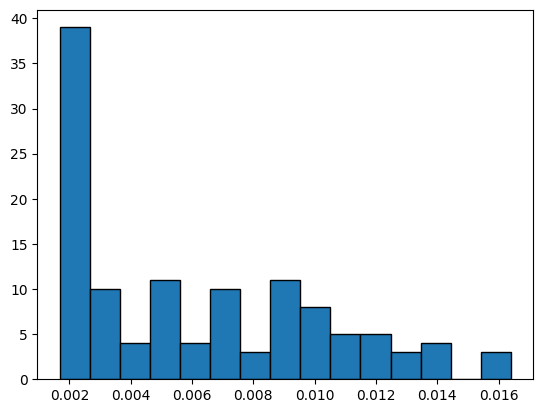

In [75]:
#Within-video MSE-Frame Distribution
plt.hist(mse_example_video, bins=15, edgecolor = 'black')
plt.xlabel('Mean Square Error')
plt.title('Distribution of Frame-by-Frame Mean Square Error for RNN')

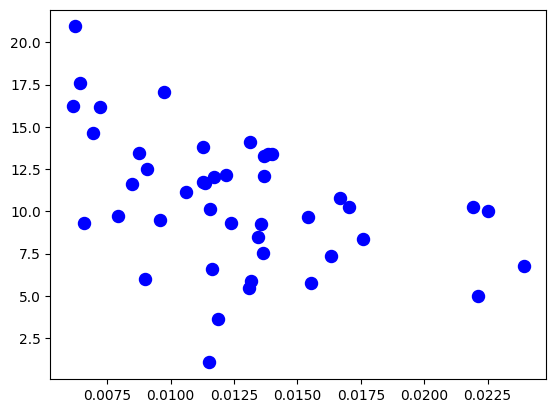

In [72]:
#Per-Video VMAF and MSE Scatterplot -- Without normalization
plt.scatter(mse_scores, vmaf_scores, color='blue', marker='o', s=75)
plt.xlabel('Mean Square Error')
plt.ylabel('VMAF Score')
plt.title('Scatterplot of Mean Square Error and VMAF Score by Video for RNN')

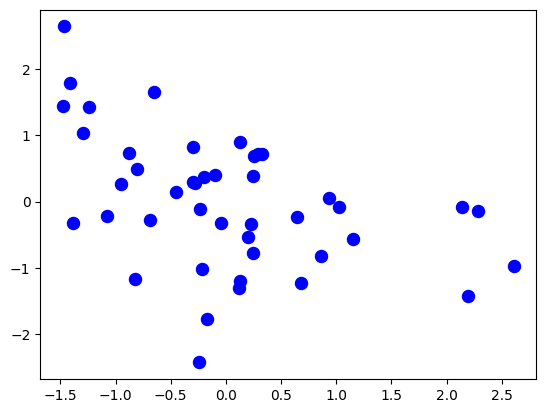

In [73]:
#Per-Video VMAF and MSE Scatterplot -- With normalization
mse_norm = (mse_scores - np.mean(mse_scores))/np.std(mse_scores)
vmaf_norm = (vmaf_scores - np.mean(vmaf_scores))/np.std(vmaf_scores)
plt.scatter(mse_norm, vmaf_norm, color='blue', marker='o', s=75)
plt.xlabel('Z-Score of Mean Square Error')
plt.ylabel('Z-Score of VMAF Score')
plt.title('Scatterplot of Normalized Mean Square Error and VMAF Score by Video for RNN')

In [74]:
np.corrcoef(mse_norm, vmaf_norm)

array([[ 1.        , -0.45313865],
       [-0.45313865,  1.        ]])